<a href="https://colab.research.google.com/github/imanuni/ilafmake/blob/main/week4-corse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Surpress warnings from using older version of sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
#await piplite.install(['pandas', 'numpy', 'seaborn', 'matplotlib', 'scikit-learn', 'plotly','openpyxl', 'nbformat>=4.2.0'])
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

**Reading and understanding our data**

For this lab, we will be using the airlines_data.xlsx file, hosted on IBM Cloud object. This dataset contains the prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities. This dataset is often used for prediction analysis of the flight prices which are influenced by various factors, such as name of the airline, date of journey, route, departure and arrival times, the source and the destination of the trip, duration and other parameters.

In this notebook, we will use the airlines dataset to perform feature engineering on some of its independent variables.

Let's start by reading the data into pandas data frame and looking at the first 5 rows using the head() method.

In [27]:
import requests
import pandas as pd

# الرابط للملف
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0232EN-SkillsNetwork/asset/airlines_data.xlsx"

# تحميل الملف من الرابط
response = requests.get(url)

# التأكد من نجاح عملية التحميل
if response.status_code == 200:
    # حفظ الملف المحمل
    with open("airlines_data.xlsx", "wb") as f:
        f.write(response.content)

    # قراءة الملف باستخدام pandas
    data = pd.read_excel("airlines_data.xlsx")

    # عرض البيانات
    print(data.head())
else:
    print("Failed to download the file.")

       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [29]:
#The describe() function provides the statistical information about the numerical variables. In our case, it is the 'price' variable.
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [30]:
#Next, we will check for any null values.
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [31]:
#Now that we have found some null points, we need to either remove them from our dataset or fill them with something else.
#In this case, we will use fillna() and method='ffill',
 #which fills the last observed non-null value forward until another non-null value is encountered.
 #لآن بعد أن وجدنا بعض النقاط الفارغة، نحتاج إما إلى إزالتها من مجموعة البيانات لدينا أو ملؤها بشيء آخر. في هذه الحالة، سوف نستخدم fillna() وmethod='ffill'،
 # الذي يملأ آخر قيمة غير فارغة تمت ملاحظتها للأمام حتى يتم العثور على قيمة غير فارغة أخرى.
data = data.fillna(method='ffill')

**Feature Transformation**
Feature Transformation means transforming our features to the functions of the original features. For example, feature encoding, scaling, and discretization (the process of transforming continuous variables into discrete form, by creating bins or intervals) are the most common forms of data transformation

In [32]:
#Categorical variables represent qualitative data with no apparent inherent mathematical meaning. Therefore, for any machine learning analysis,
# all the categorical data must be transformed into the numerical data types. First, we'll start with 'Airlines' column, as it contains categorical values
# We will use unique() method to obtain all the categories in this column.
data['Airline'].unique().tolist()

['IndiGo',
 'Air India',
 'Jet Airways',
 'SpiceJet',
 'Multiple carriers',
 'GoAir',
 'Vistara',
 'Air Asia',
 'Vistara Premium economy',
 'Jet Airways Business',
 'Multiple carriers Premium economy',
 'Trujet']

In [33]:
#From the above list, we notice that some of the airline names are being repeated.
# For example, 'Jet Airways' and 'Jet Airways Business'. This means that some of the airlines are subdivided into separate parts.
# We will combine these 'two-parts' airlines to make our categorical features more consistent with the rest of the variables.
#Here, we will use the numpy where() function to locate and combine the two categories.
data['Airline'] = np.where(data['Airline']=='Vistara Premium economy', 'Vistara', data['Airline'])
data['Airline'] = np.where(data['Airline']=='Jet Airways Business', 'Jet Airways', data['Airline'])

In [34]:
#Exercise 1
#n this exercise, use np.
#where() function to combine 'Multiple carriers Premium economy' and 'Multiple carriers' categories,
# like shown in the code above. Print the newly created list using unique().tolist() functions.
data['Airline'] = np.where(data['Airline']=='Multiple carriers Premium economy','Multiple carriers',data['Airline'])
data['Airline'].unique().tolist()

['IndiGo',
 'Air India',
 'Jet Airways',
 'SpiceJet',
 'Multiple carriers',
 'GoAir',
 'Vistara',
 'Air Asia',
 'Trujet']

In [35]:
#One Hot Encoding
#Now, to be recognized by a machine learning algorithms, our categorical variables should be converted into numerical ones.
# One way to do this is through one hot encoding. To learn more about this process, please visit this documentation.
#We will use, get_dummies() method to do this transformation. In the next cell, we will transform 'Airline',
# 'Source', and 'Destination' into their respective numeric variables. We will put all the transformed data into a 'data1' data frame.
data1 = pd.get_dummies(data=data, columns = ['Airline', 'Source', 'Destination'])

In [36]:
data1.head()


,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Airline_Air Asia,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,24/03/2019,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1/05/2019,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,False,True,...,False,False,True,False,True,False,False,False,False,False
2,9/06/2019,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,False,False,...,False,True,False,False,False,True,False,False,False,False
3,12/05/2019,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,False,False,...,False,False,True,False,True,False,False,False,False,False
4,01/03/2019,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,False,False,...,False,False,False,False,False,False,False,False,False,True


In [37]:
#Below, we will compare our original data frame with the transformed one
data.shape

(10683, 11)

In [38]:
#As we can see, we went from 11 original features in our dataset to 38.
#This is because Pandas get_dummies() approach when applied to a column with different categories
# (e.g. different airlines) will produce a new column (variable) for each unique categorical value (for each unique airline).
# It will place a one in the column corresponding to the categorical value present for that observation
data1.shape

(10683, 28)

In [39]:
#Exercise 2
#In this exercise, use value_counts() to determine the values distribution of the 'Total_Stops' parameter.
data['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3492
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [40]:
#Label Encoding
#Since 'Total_Stops' is originally a categorical data type, we also need to convert it into numerical one.
#For this, we can perform a label encoding, where values are manually assigned to the corresponding keys, like "0" to a "non-stop", using the replace() function.
data1.replace({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4},inplace=True)
data1.head()

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Airline_Air Asia,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,24/03/2019,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1/05/2019,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,False,True,...,False,False,True,False,True,False,False,False,False,False
2,9/06/2019,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,False,False,...,False,True,False,False,False,True,False,False,False,False
3,12/05/2019,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,False,False,...,False,False,True,False,True,False,False,False,False,False
4,01/03/2019,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,False,False,...,False,False,False,False,False,False,False,False,False,True


**Transforming the 'Duration' time column**
Here, we will take a closer look at the 'Duration' variable. Duration is the time taken by a plane to reach its destination. It is the difference between the 'Dep_Time' and 'Arrival_Time'. In our dataset, the 'Duration' is expressed as a string, in hours and minutes. To be recognized by machine learning algorithms, we also need to transform it into numerical type.

The code below will iterate through each record in 'Duration' column and split it into hours and minutes, as two additional separate columns. Also, we want to add the 'Duration_hours' (in minutes) to the 'Duration_minutes' column to obtain a 'Duration_Total_mins' time, in minutes. The total duration time column will be useful feature for any regression type of analysis.

In [43]:
duration = list(data1['Duration'])
for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())
dur_hours = []
dur_minutes = []

for i in range(len(duration)) :
    dur_hours.append(int(duration[i].split()[0][:-1]))
    dur_minutes.append(int(duration[i].split()[1][:-1]))


data1['Duration_hours'] = dur_hours
data1['Duration_minutes'] =dur_minutes
data1.loc[:,'Duration_hours'] *= 60
data1['Duration_Total_mins']= data1['Duration_hours']+data1['Duration_minutes']
data1.head()

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Airline_Air Asia,Airline_Air India,...,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Duration_hours,Duration_minutes,Duration_Total_mins
0,24/03/2019,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,False,False,...,False,False,False,False,False,False,True,120,50,170
1,1/05/2019,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,False,True,...,False,True,False,False,False,False,False,420,25,445
2,9/06/2019,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,False,False,...,False,False,True,False,False,False,False,1140,0,1140
3,12/05/2019,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,False,False,...,False,True,False,False,False,False,False,300,25,325
4,01/03/2019,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,False,False,...,False,False,False,False,False,False,True,240,45,285


In [44]:
#Transforming the 'Departure' and 'Arrival' Time Columns
#Now, we will transform the 'Dep_Time' and 'Arrival_Time' columns to the appropriate date and time format. We will use pandas to_datetime() function for this.
#We will split the 'Dep_Time' and 'Arrival_Time' columns into their corresponding hours and minutes columns.
data1["Dep_Hour"]= pd.to_datetime(data1['Dep_Time']).dt.hour
data1["Dep_Min"]= pd.to_datetime(data1['Dep_Time']).dt.minute

In [45]:
#Exercise 3
#Now, let's transform the 'Arrival_Time' column.
data1['Arrival_Hour']=pd.to_datetime(data1['Arrival_Time']).dt.hour
data1['Arrival_Min']=pd.to_datetime(data1['Arrival_Time']).dt.minute


In [46]:
#Splitting 'Departure/Arrival_Time' into Time Zones
#To further transform our 'Departure/Arrival_Time' column, we can break down the 24 hours format for the departure and arrival time
# into 4 different time zones: night, morning, afternoon, and evening. This might be an interesting feature engineering technique to see what time of a day has the most arrivals/departures.
#One way to do this is transformation is by using pandas cut() function.
data1['dep_timezone'] = pd.cut(data1.Dep_Hour, [0,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])
data1['dep_timezone']

0          Evening
1            Night
2          Morning
3        Afternoon
4        Afternoon
           ...    
10678      Evening
10679      Evening
10680      Morning
10681      Morning
10682      Morning
Name: dep_timezone, Length: 10683, dtype: category
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

In [53]:
#Exercise 4
#Now, let's transform the 'Arrival_Time' column into its corresponding time zones, as shown in the example above.
#[0,6,12,18,24] : Ce sont les limites des intervalles. Par exemple, [0,6) représente la plage de 0 à 6 heures non inclus, [6,12) représente la plage de 6 à 12 heures non inclus,
#et ainsi de suite jusqu'à [18,24) qui représente la plage de 18 à 24 heures non inclus.
data1['arrival_timezone'] = pd.cut(data1.Arrival_Hour, [0,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])
selected_columns = data1.loc[:, ['arrival_timezone', 'Arrival_Hour']]
print(selected_columns)


      arrival_timezone  Arrival_Hour
0                Night             1
1            Afternoon            13
2                Night             4
3              Evening            23
4              Evening            21
...                ...           ...
10678          Evening            22
10679          Evening            23
10680          Morning            11
10681        Afternoon            14
10682          Evening            19

[10683 rows x 2 columns]


In [54]:
#Transforming the 'Date_of_Journey' Column
#Similar to the departure/arrival time, we will now extract some information from the 'date_of_journey' column,
# which is also an object type and can not be used for any machine learning algorithm yet.
#So, we will extract the month information first and store it under the 'Month' column name.
data1['Month']= pd.to_datetime(data1["Date_of_Journey"], format="%d/%m/%Y").dt.month

In [58]:
#Exercise 5
#Now, let's create 'Day' and 'Year' columns in a similar way.
data1['Day']= pd.to_datetime(data1["Date_of_Journey"], format="%d/%m/%Y").dt.day
data1['Year']= pd.to_datetime(data1["Date_of_Journey"], format="%d/%m/%Y").dt.year
#Additionally, we can extract the day of the weak name by using dt.day_name() function.
data1['day_of_week'] = pd.to_datetime(data1['Date_of_Journey']).dt.day_name()
selected_columns1 = data1.loc[:, ['Day', 'Year','day_of_week']]
print(selected_columns1)

       Day  Year day_of_week
0       24  2019      Sunday
1        1  2019   Wednesday
2        9  2019      Sunday
3       12  2019      Sunday
4        1  2019      Friday
...    ...   ...         ...
10678    9  2019     Tuesday
10679   27  2019    Saturday
10680   27  2019    Saturday
10681    1  2019      Friday
10682    9  2019    Thursday

[10683 rows x 3 columns]


***Feature Selection***
Here, we will select only those attributes which best explain the relationship of the independent variables with respect to the target variable, 'price'. There are many methods for feature selection, building the heatmap and calculating the correlation coefficients scores are the most commonly used ones.

First, we will select only the relevant and newly transformed variables (and exclude variables such as 'Route', 'Additional_Info', and all the original categorical variables), and place them into a 'new_data' data frame.

We will print all of our data1 columns.

In [59]:
data1.columns

Index(['Date_of_Journey', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration',
       'Total_Stops', 'Additional_Info', 'Price', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_Total_mins', 'Dep_Hour',
       'Dep_Min', 'Arrival_Hour', 'Arrival_Min', 'dep_timezone',
       'arrival_timezone', 'Month', 'Day', 'Year', 'day_of_week'],
      dtype='object')

In [62]:
new_data = data1.loc[:,['Total_Stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_Total_mins', 'Dep_Hour',
       'Dep_Min', 'Price']]

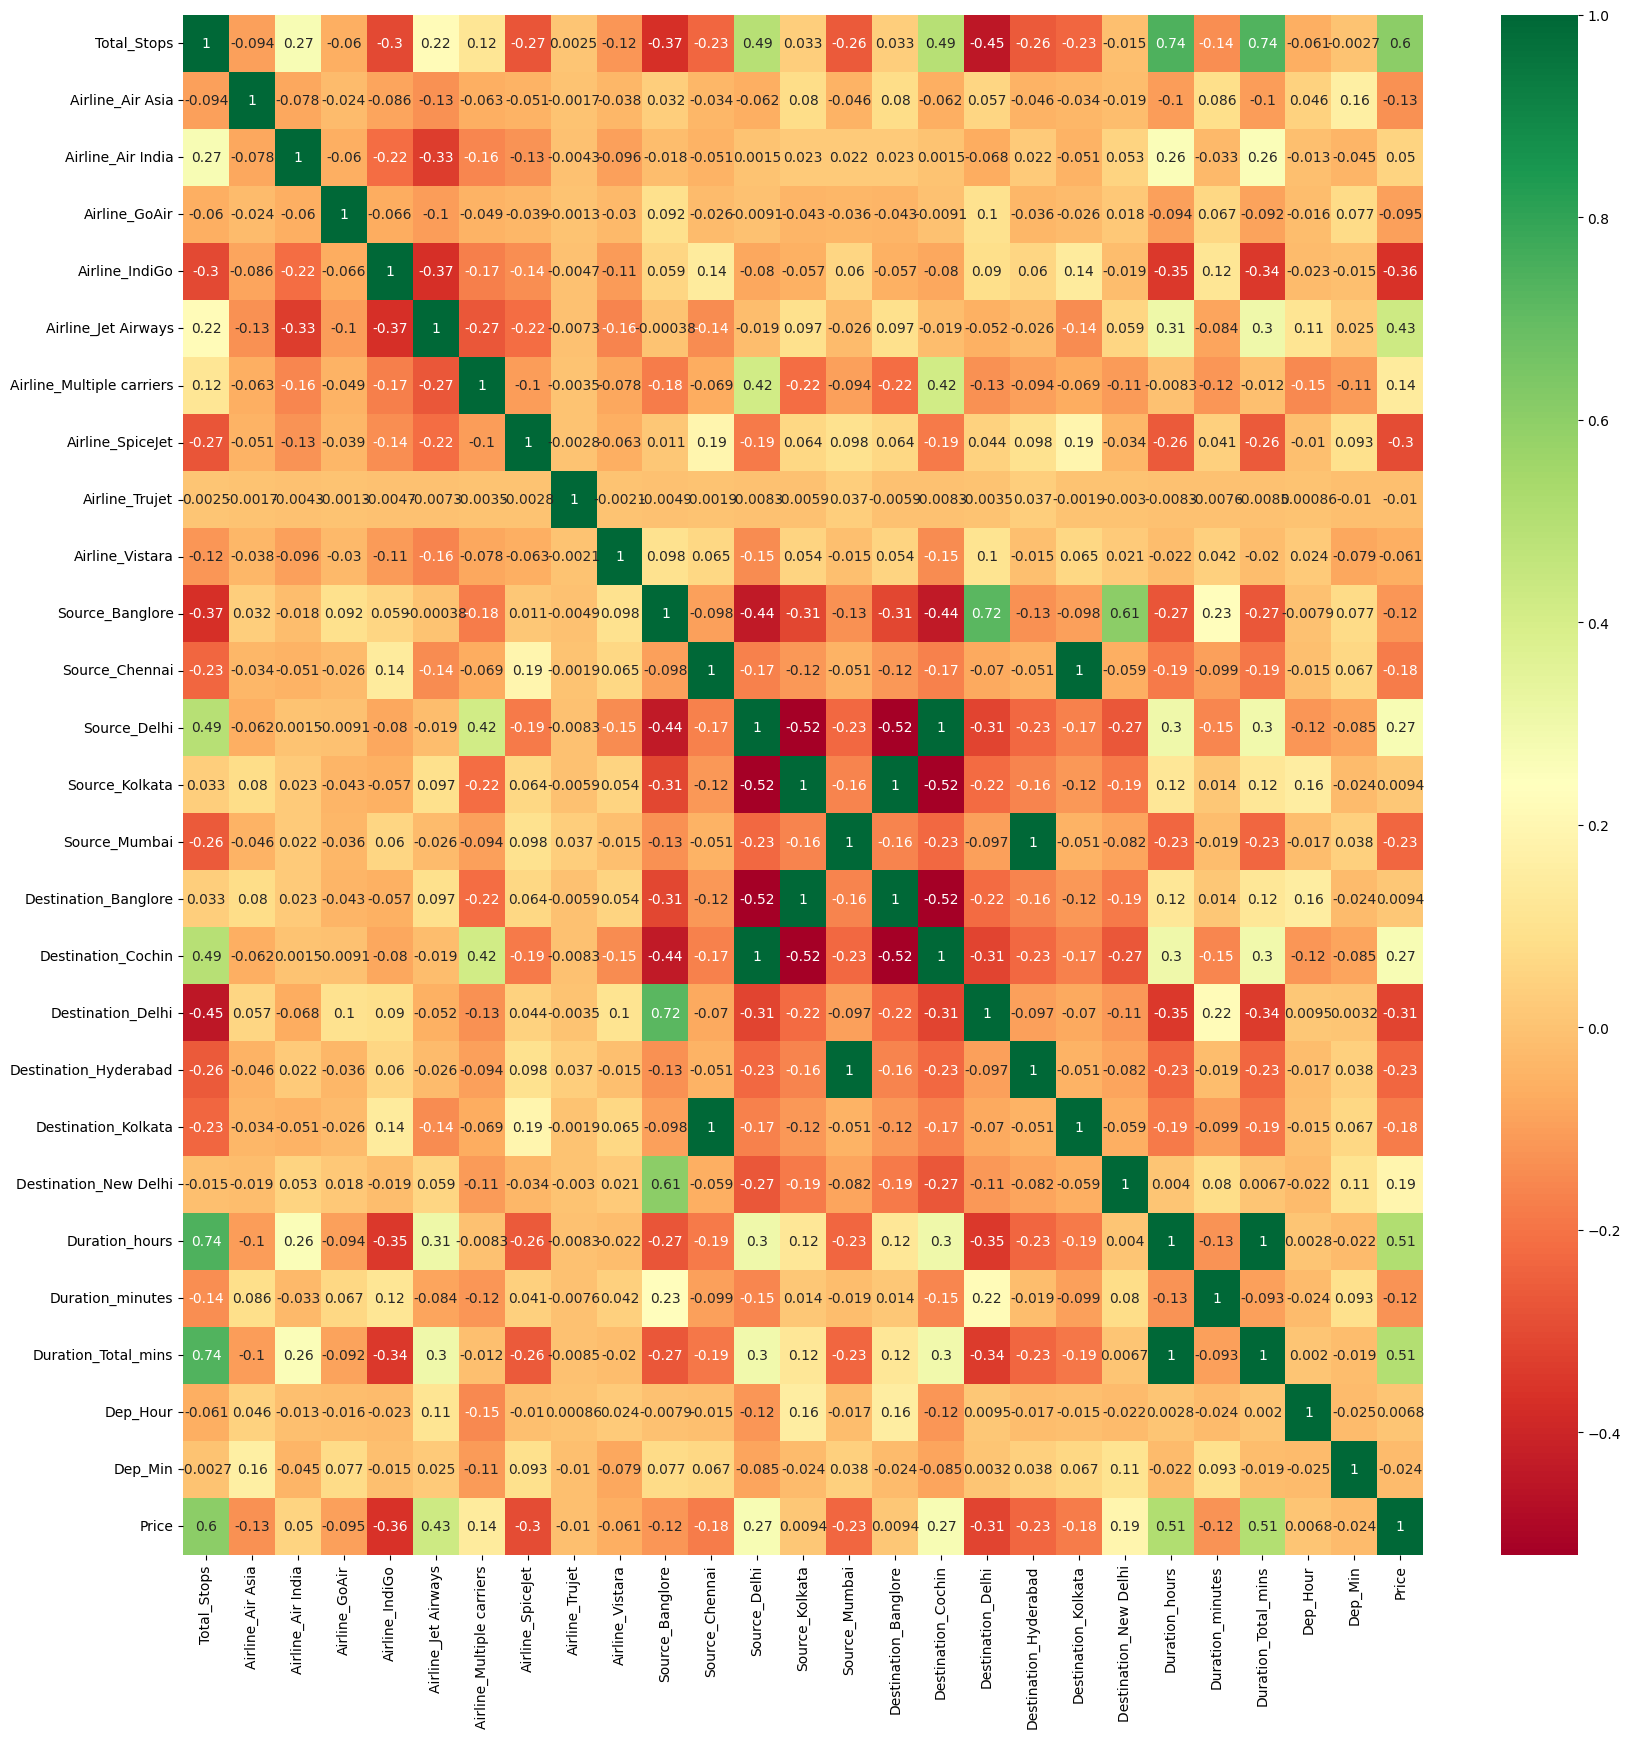

In [64]:
#Now we will construct a heatmap(), using the seaborn library with a newly formed data frame, 'new_data'.
plt.figure(figsize=(20,20))
sns.heatmap(new_data.corr(),annot=True,cmap='RdYlGn')

plt.show()

In [65]:
#From the heatmap above, extreme green means highly positively correlated features (relationship between two variables in which both variables move in the same direction),
# extreme red means negatively correlated features (relationship between two variables in which an increase in one variable is associated with a decrease in the other).
#Now, we can use the corr() function to calculate and list the correlation between all independent variables and the 'price'.
features = new_data.corr()['Price'].sort_values()
features

Airline_IndiGo              -0.361048
Destination_Delhi           -0.313401
Airline_SpiceJet            -0.296552
Destination_Hyderabad       -0.230745
Source_Mumbai               -0.230745
Destination_Kolkata         -0.179216
Source_Chennai              -0.179216
Airline_Air Asia            -0.133044
Duration_minutes            -0.124874
Source_Banglore             -0.118026
Airline_GoAir               -0.095146
Airline_Vistara             -0.060503
Dep_Min                     -0.024492
Airline_Trujet              -0.010380
Dep_Hour                     0.006819
Source_Kolkata               0.009377
Destination_Banglore         0.009377
Airline_Air India            0.050346
Airline_Multiple carriers    0.141087
Destination_New Delhi        0.189785
Destination_Cochin           0.270619
Source_Delhi                 0.270619
Airline_Jet Airways          0.428490
Duration_Total_mins          0.506371
Duration_hours               0.508672
Total_Stops                  0.603891
Price       

<Axes: >

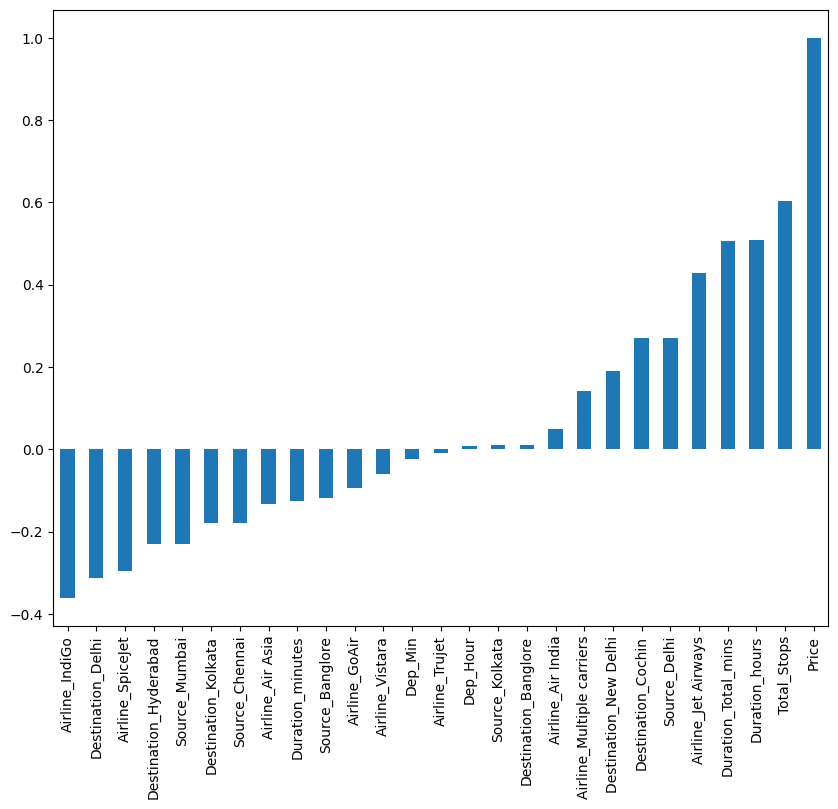

In [66]:
#We can also plot these correlation coefficients for easier visualization.
features.plot(kind='bar',figsize=(10,8))

Dimentionality reduction is part of the feature extraction process that combines the existing features to produce more useful ones. The goal of dimensionality reduction is to simplify the data without loosing too much information. Principal Component Analysis (PCA) is one of the most popular dimensionality reduction algorithms. First, it identifies the hyperplane that lies closest to the data, and then it projects the data onto it. In this way, a few multidimensional features are merged into one.

In the following portion of the lab, we will use scikit-learn library to perform some PCA on our data. To learn more about scikit-learn PCA, please visit this documentation.

In [67]:
#First, we must scale our data using the StandardScaler() function. We will assign all the independent variables to x, and the dependent variable, 'price', to y.
x = data1.loc[:,['Total_Stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_Total_mins', 'Dep_Hour',
       'Dep_Min']]

In [69]:
y=data1.Price

In [70]:
scaler = StandardScaler()
x=scaler.fit_transform(x.astype(np.float64))
x

array([[-1.22052384, -0.17544122, -0.44291155, ..., -0.93158255,
         1.65425948, -0.23505036],
       [ 1.74150619, -0.17544122,  2.25778713, ..., -0.39007152,
        -1.30309491,  1.36349161],
       [ 1.74150619, -0.17544122, -0.44291155, ...,  0.97847452,
        -0.60724682,  0.0313733 ],
       ...,
       [-1.22052384, -0.17544122, -0.44291155, ..., -0.91189124,
        -0.78120884, -0.23505036],
       [-1.22052384, -0.17544122, -0.44291155, ..., -0.95127386,
        -0.25932278,  0.29779696],
       [ 1.74150619, -0.17544122,  2.25778713, ..., -0.28176932,
        -0.4332848 ,  1.62991527]])

In [71]:
#Once the data is scaled, we can apply the fit_transform() function to reduce the dimensionality of the dataset down to two dimensions.
pca = PCA(n_components = 2)
pca.fit_transform(x)

array([[-2.8756079 , -0.5548276 ],
       [ 0.3188366 ,  2.39209744],
       [ 3.05932833, -0.527242  ],
       ...,
       [-2.24750206, -0.58940768],
       [-2.69897523, -0.28809116],
       [ 1.92548476, -1.10443486]])

Explained Variance Ratio
Another useful piece of information in PCA is the explained variance ratio of each principal component, available via the explained_variance_ratio_ function. The ratio indicates the proportion of the dataset's variance that lies along each principal component. Let's look at the explained variance ratio of each of our two components.



In [72]:
explained_variance=pca.explained_variance_ratio_
explained_variance
#The first component constitutes 17.54% of the variance and second component constitutes 12.11% of the variance between the features.

array([0.17545521, 0.12110717])

In [73]:
#Exercise 6 (Optional)
#In this exercise, experiment with the number of components to see how many dimensions our dataset could be reduced to
#in order to explain most of the variability between the features. Additionally, you can plot the components using bar plot to see how much variability each component represents.
pca = PCA(n_components = 7)
pca.fit_transform(x)
explained_variance=pca.explained_variance_ratio_
explained_variance


array([0.17545521, 0.12110719, 0.0926492 , 0.08280111, 0.06739565,
       0.05275645, 0.04819541])

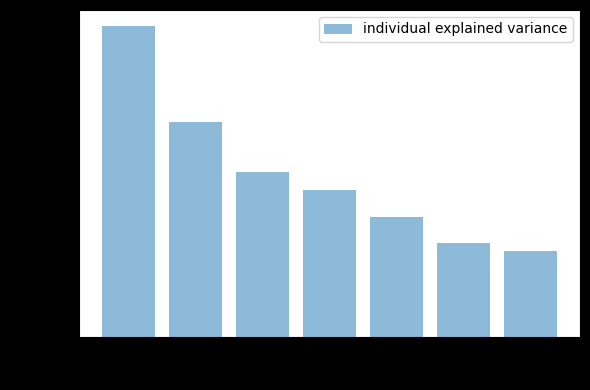

In [76]:

# use proper indentation with this block of code
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))


plt.bar(range(7), explained_variance, alpha=0.5, align='center',
label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

Choosing the Right Number of Dimensions
Instead of arbitrary choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large proportion of the variance, let's say 95%.

The following code performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the variance.

In [77]:
pca = PCA()
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >=0.95) + 1
d

16

In [78]:
#There are 16 components required to meet 95% variance. Therefore, we could set n_components = 16 and run PCA again.
#However, there is better way, instead of specifying the number of principal components you want to preserve,
#you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve.
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x)

In [79]:
#There is also a graphical way to determine the number of principal components in your analysis.
# It is to plot the explained variance as a function of the number of dimensions. There will usually be an elbow in the curve,
# where the explained variance stops growing fast. That point is usually the optimal point for the number of principal components.
px.area(
    x=range(1, cumsum.shape[0] + 1),
    y=cumsum,
    labels={"x": "# Components", "y": "Explained Variance"}
)
